**Instructor**: Prof. Peter Beerel (pabeerel@usc.edu)

**Teaching Assistant**: Alexios Rustom (arustom@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Linear Unsupervised Learning

In [1]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
import copy
import math
from matplotlib import gridspec
from sklearn import datasets
readDataPath = './readData/'

In [2]:
def center(X):
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means
    return X_normalized

In [3]:
def vector_draw(vec,ax,**kwargs):
    color = 'k'
    if 'color' in kwargs:
        color = kwargs['color']
    zorder = 3 
    if 'zorder' in kwargs:
        zorder = kwargs['zorder']
        
    veclen = math.sqrt(vec[0]**2 + vec[1]**2)
    head_length = 0.25
    head_width = 0.25
    vec_orig = copy.deepcopy(vec)
    vec = (veclen - head_length)/veclen*vec
    ax.arrow(0, 0, vec[0],vec[1], head_width=head_width, head_length=head_length, fc=color, ec=color,linewidth=3,zorder = zorder)

In [4]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd import hessian
from autograd.misc.flatten import flatten_func

def gradient_descent(g,alpha_choice,max_its,w):
    
    # flatten the input function to more easily deal with costs that have layers of parameters
    g_flat, unflatten, w = flatten_func(g, w) # note here the output 'w' is also flattened

    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g_flat)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current (unflattened) weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g_flat(w))  
    return weight_history,cost_history

In [5]:
def plot_hyperplane(data,slopes,ax):
    # define input space
    xmin = np.min(data[:,0])
    xmax = np.max(data[:,0])
    xgap = (xmax - xmin)*0.1
    xmin -= xgap
    xmax += xgap
    
    ymin = np.min(data[:,1])
    ymax = np.max(data[:,1])
    ygap = (ymax - ymin)*0.1
    ymin -= ygap
    ymax += ygap
    
    # create meshgrid
    xrange = np.linspace(xmin,xmax,200)
    yrange = np.linspace(ymin,ymax,200)
    w1_vals, w2_vals = np.meshgrid(xrange,yrange)
    w1_vals.shape = (len(xrange)**2,1)
    w2_vals.shape = (len(yrange)**2,1)
    
    # compute normal vector to plane
    normal_vector = np.cross(slopes[:,0], slopes[:,1])
    normal_vector = normal_vector/(-normal_vector[-1])
    
    # hyperplane function
    func = lambda w: normal_vector[0]*w[0] + normal_vector[1]*w[1]

    # evaluate hyperplane
    zvals = func([w1_vals,w2_vals]) 

    # vals for cost surface, reshape for plot_surface function
    w1_vals.shape = (len(xrange),len(xrange))
    w2_vals.shape = (len(yrange),len(yrange))
    zvals.shape = (len(xrange),len(yrange))

    ### plot function and z=0 for visualization ###
    ax.plot_surface(w1_vals, w2_vals, zvals, alpha = 0.1,color = 'r',zorder = 2)

In [6]:
def move_axis_left(ax):
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                        tmp_planes[0], tmp_planes[1], 
                        tmp_planes[4], tmp_planes[5])   
    ax.grid(False)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('white')
    ax.yaxis.pane.set_edgecolor('white')
    ax.zaxis.pane.set_edgecolor('white')

## Fixed Spanning Sets, Orthonormality, and Projections

- Lets suppose our set of input points - our *dataset* - is written as  \{$\mathbf{x}_1,\,\mathbf{x}_2,\,...,\mathbf{x}_P\}$ and lives in $N$ dimensions (that is, each point is $N$ dimensional). 


- Moreover throughout we will assume that our dataset has been *mean-centered* - a simple and completely reversible operation that involves subtracting off the mean of the dataset along each input dimension - so that it straddles the origin.


- This sort of normalization is almost always done in practice, and is computationally inexpensive to execute. 

- Remember when thinking about data points in a multi-dimensional *vector space*, we can think of them simultaneously as 'dots' or as 'arrows'. 


- When thinking about *spanning sets of vectors* it is often helpful to visualize points in the same space using both of these conventions - i.e., some as 'dots' and others as 'arrows'.

- Those vectors drawn as arrows are particular points - often called a *basis* or *spanning set of vectors* - over which we aim to efficiently represent every other point in the space.  


- Those other vectors shown as dots are those points we wish to represent over our basis / spanning set.

- In order for our basis / spanning set to be capable of perfectly representing all $P$ of our points it too must live in the same $N$ dimensional space.  


- For a candidate basis / spanning set $\mathbf{c}_1,\,\mathbf{c}_2,...,\mathbf{c}_N$ to be capable of perfectly representing such generic $N$ dimensional (input) data means...


- ...that for each data point a set of weights exists so that, in particular linear combination, our basis set can match each data point as

\begin{equation}
\sum_{n=1}^N \mathbf{c}_n w_{n,\,p} = \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P.
\end{equation}

- Technically speaking in order for this possibility to exist our spanning set must be *linearly independent* 


- that is, the spanning vectors do not 'overlap', they point in completely different directions in the space.

- As the simplest example imagine our spanning set was the set of $N$ *standard basis vectors*. The $n^{th}$ element of a standard basis takes the form of vectors that consist entirely of zeros, except for a $1$ in its $n^{th}$ slot

\begin{equation}
\text{($n^{th}$ element of the standard basis)}\,\,\,\,\,\,\,\, \mathbf{c}_n = 
\begin{bmatrix}
0 \\ 
\vdots \\
0 \\
1 \\
0 \\
\vdots \\
0
\end{bmatrix}.
\end{equation}

- To represent a data point $\mathbf{x}_p$ over the standard basis is a trivial affair, and one can easily check that the perfect weights must be defined as

\begin{equation}
w_{n,\,p} = x_{n,\,p}
\end{equation}

- i.e., each weight is simply equal to the value of the data point we aim to represent.  


- For most any other spanning set however these weights must be solved for numerically, which we frame in terms of a cost function minimization.

- If indeed the spanning set of vectors is linearly independent, then having properly tuned the weights of point $\mathbf{x}_p$, denoted as the $N$ length vector

\begin{equation}
 \mathbf{w}_p = \begin{bmatrix}  w_{1,\,p} \\ w_{2,\,p} \\ \vdots \\ w_{N,\,p} \end{bmatrix}
 \end{equation}


- This weight set provides the new representation of $\mathbf{x}_p$ with respect to the spanning set. 


- For example, in the trivial case where our spanning set consists of the standard basis our representation or feature vector $\mathbf{w}_p = \mathbf{x}_p$ is the data point itself!  


- Otherwise $\mathbf{w}_p$ - typically referred to as the new **encoding** of $\mathbf{x}_p$* in the *transformed feature space* whose coordinate axes are defined by the spanning set - is a vector that differs from original data point. 

 One way we can solve for the proper weights is by setting up / minimizing an appropriate cost function.  


- It is natural (as in our development of e.g., linear regression) to have $\left(\sum_{n=1}^N \mathbf{c}_n w_{p,n} - \mathbf{x}_p\right)^2$ 


- We then tune the corresponding weights to make this squared error as small as possible. 


- So for each data point $\mathbf{x}_p$ we have a cost function 

\begin{equation}
g\left(w_{1,\,p},...,w_{N,\,p}\right) = \left(\sum_{n=1}^N \mathbf{c}_n w_{n,\,p} - \mathbf{x}_p\right)^2  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}


- When minimized appropriately provides us with a proper set of parameters for representing $\mathbf{x}_p$ over the spanning set. 


- While we could certainly use an iterative method like gradient descent to minimize this single-point cost, here we can in fact directly setup and solve the of equations.


- It is perhaps easiest to see this by writing the above cost function more compactly as

\begin{equation}
h\left(\mathbf{w}_p\right) = \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}


- Here the $N\times N$ matrix $\mathbf{C}$ is formed by stacking the spanning set vectors column-wise, and the $N\times 1$ vectors $\mathbf{w}_p$ as 

\begin{equation}
\mathbf{C} = 
\begin{bmatrix}
\vert \,\,\,\,\, \vert \,\,\, \cdots  \, \vert \\
\mathbf{c}_1 \,\,\, \mathbf{c}_2 \,\,\,\,\,\, \mathbf{c}_N \\
\vert \,\,\,\,\, \vert \,\,\, \cdots  \, \vert 
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\, 
\mathbf{w}_p = 
\begin{bmatrix}
 w_{p,1} \\
 w_{p,2} \\
 \vdots  \\
 w_{p,N}
\end{bmatrix}
\end{equation}

- Now setting the gradient of the cost function to zero and solving for $\mathbf{w}_p$ gives the linear symmetric system of equations for each $\mathbf{w}_p$


- which we can conveniently write algebraically as 

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,}\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P.
\end{equation}

- Numerically this sort of symmetric system of equations can be solved via e.g., coordinate descent. 


- Once these are solved for - and we have our learned weights $\hat{\mathbf{w}}_p$ -  we can then perfectly represent a point $\mathbf{x}_p$ over the spanning set as we desired in equation (1) as 

\begin{equation}
\mathbf{C}\hat{\mathbf{w}}_p  = \sum_{n=1}^N \mathbf{c}_n \hat{w}_{n,\,p} = \mathbf{x}_p.
\end{equation}

- Notice here that we can take the average of the individual single-point cost functions, giving a cost function over the entire dataset

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

- This is just a convenient way of writing out the entire list of $P$ single-point cost functions together


- i.e., we get no new solution methods by doing this, as the joint cost decomposes over the weight vectors $\mathbf{w}_p$.

- Formally then our optimization problem to recover all of the proper weight vectors can be expressed as

\begin{equation}
\underset{\mathbf{w}_1,\mathbf{w}_2,...,\mathbf{w}_P}{\text{minimize}} \,\, \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

In [7]:
X_original = np.loadtxt(readDataPath + '2d_span_data.csv',delimiter=',')

In [8]:
X = center(X_original)

In [9]:
C = np.array([[2,1],[1,2]])

In [10]:
X_new = copy.deepcopy(X)
X_new = X.T

In [11]:
# swing through points and compute coeffecients
alphas = []
for k in range(X_new.shape[0]):
    vec3 = X_new[k,:]   
    vec3.shape = (len(vec3),1)
    b = vec3
    alpha = np.linalg.solve(C,b)
    alphas.append(alpha)

In [12]:
alphas = np.stack(alphas, axis=0 )

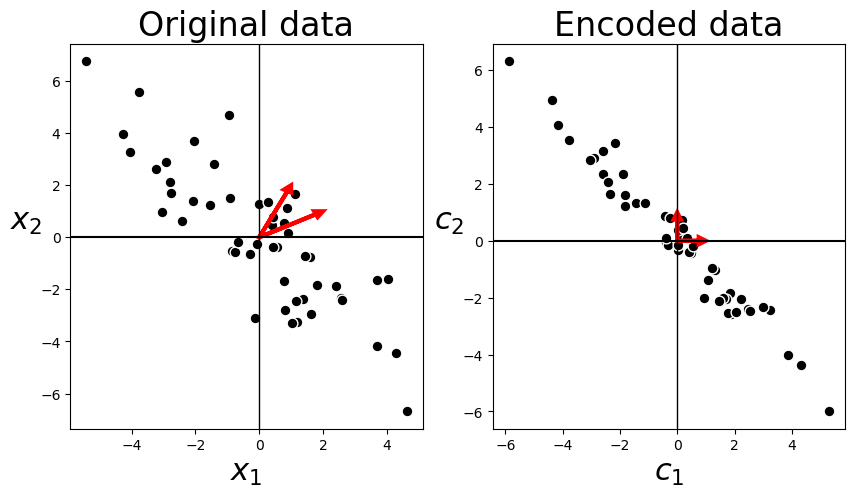

In [13]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X_new[:,0],X_new[:,1],s = 60, c = 'k',edgecolor = 'w',linewidth = 1)
ax2.scatter(alphas[:,0],alphas[:,1],s = 60, c = 'k',edgecolor = 'w',linewidth = 1)

vector_draw(C[:,0].flatten(),ax1,color = 'red',zorder = 1)
vector_draw(C[:,1].flatten(),ax1,color = 'red',zorder = 1)
vec1 = np.array([1,0]).flatten()
vec2 = np.array([0,1]).flatten()
vector_draw(vec1.flatten(),ax2,color = 'red',zorder = 1)
vector_draw(vec2.flatten(),ax2,color = 'red',zorder = 1)
ax1.axhline(y=0, color='k', linewidth=1.5,zorder = 1)
ax1.axvline(x=0, color='k', linewidth=1,zorder = 1)
ax2.axhline(y=0, color='k', linewidth=1.5,zorder = 1)
ax2.axvline(x=0, color='k', linewidth=1,zorder = 1)
ax1.set_xlabel(r'$x_1$',fontsize = 22)
ax1.set_ylabel(r'$x_2$',fontsize = 22,rotation = 0,labelpad = 10)
ax1.set_title('Original data',fontsize = 24)
ax2.set_xlabel(r'$c_1$',fontsize = 22)
ax2.set_ylabel(r'$c_2$',fontsize = 22,rotation = 0,labelpad = 10)
ax2.set_title('Encoded data',fontsize = 24)
plt.show()

###  Perfect representation using a fixed orthonormal spanning set

- A very special kind of basis / spanning set one often sees when representing data points is one whose elements are *perpendicular* and *unit length*.  


- Such a spanning set $\mathbf{c}_1,\,\mathbf{c}_2,\,...\,\mathbf{c}_N$ is one that spans an entire space, but whose elements are perpendicular have length one. 


- Algebraically this is written as 

$$
\
\mathbf{c}_n^T\mathbf{c}_m^{\,} = 0 \\
\left \Vert \mathbf{c}_n \right \Vert_2^2 = 1 \,\,\,\,\text{for}\,\,n=1...N.
$$

- Note that the same constraints expressed in terms of the concatenated basis matrix $\mathbf{C}$ can be written compactly as 

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}.
\end{equation}

- Often such a spanning sets are likewise referred to as *orthonormal* or - sometimes - *orthogonal*


- Technically speaking the latter term should only be applied when a set of vectors consists of perpendicular elements that are not necessarily unit-length, it is unfortunately often used to refer to unit-length perpendicular vectors as well. 

- Lets express the particular weights over which a dataset of $P$ points is represented over an orthonormal basis.


- Thus the "system of equations" providing the ideal weight vector or *encoding* $\mathbf{w}_p$ for each data point $\mathbf{x}_p$ over an orthonormal basis of vectors is given simply by 

\begin{equation}
\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p      \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1...P.
\end{equation} 

- In other words, if a basis / spanning set is orthonormal there is no system of equations left to solve for - we get the solution / encoded version $\mathbf{w}_p$ of each point $\mathbf{x}_p$ directly as a simple inner product of the spanning set against each data point!  


- Practically speaking this means that computing the weight vector or encoding $\mathbf{w}_p$ of a point $\mathbf{x}_p$ is considerably cheaper if our spanning set is orthonormal.


- Note further how here how we can - with these ideal weights solved for - express our data representation over an orthonormal spanning set in equation (1) very nicely in vector / matrix notation as

\begin{equation}
\mathbf{C}\,\mathbf{C}^T\mathbf{x}_p = \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1...P.
\end{equation}


- So in short, when the spanning set is orthonormal the entire set of encodings of a dataset can be expressed strictly in terms of the spanning set and the data itself.


- We call this the *Autoencoder* formula since it expresses how a point $\bm{x}_p$ is first *encoded* (via $\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$) and then decoded back to itself ($\mathbf{C}\mathbf{w}_p= \mathbf{C} \mathbf{C}^T \mathbf{x}_p$)

- This is because with orthonormal spanning sets we also have that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$, and the two transformations we apply to the data, the *encoding* transformation $\mathbf{C}^T$ and the *decoding* transformation $\mathbf{C}$, are inverse operations.

###  Imperfectly representing data using a fixed spanning set

- Above we reviewed two important facts that we require for a spanning set / basis in order for it to be capable of perfectly representing points in a generic $N$ dimensional space:


-  The set of vectors are *linearly independent*, that is they point in different directions in the space


- There are at least $N$ spanning vectors

- What happens when we relax the second condition and suppose we more generally have $K\leq N$ spanning vectors / basis elements?  


- Unsurprisingly we can no longer perfectly represent a generic set of $P$ points in the space. 


- In $N$ dimensions this set of $K$ vectors can - at best - span a $K$ dimensional subspace.  

- For example as illustrated in the figure below, if $N=3$ the best any set of $K=2$ spanning vectors can do is span a hyperplane.  


- A set consisting of a single $K = 1$ spanning vector can only span a line.  


- In both instances we clearly will not be able to perfectly represent all possible points in a space, since our reach in each case is restricted to a lower dimensional *subspace* of the full space. 

- While we may not be able to perfectly represent a given point or set of points in the space, we can try our best.  


- Mirroring the setup we saw above with a complete basis, the same logic then leads us to the Least Squares cost function (a generalization of equation (4) above) for each data point

\begin{equation}
g\left(w_{1,\,p},...w_{K,\,p}\right) = \left(\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} - \mathbf{x}_p\right)^2   \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

- here the only difference from the original cost function is that we now only have $K$ spanning set vectors.  

- Likewise we can derive the similar looking *first order system* of symmetric equations providing our ideal weights or encoding vectors $\mathbf{w}_p$, writing them neatly using the compact vector / matrix notation established previously as

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,}\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P.
\end{equation}

- Here there is of course only one caveat: since we have only $K$ spanning set vectors the matrix $\mathbf{C}$ is $N\times K$, consisting of only our $K$ spanning vectors lined up column-wise 
$\mathbf{C} = 
\begin{bmatrix}
\vert \,\,\,\,\, \vert \,\,\, \cdots  \, \vert \\
\mathbf{c}_1 \,\,\, \mathbf{c}_2 \,\,\,\,\,\, \mathbf{c}_K \\
\vert \,\,\,\,\, \vert \,\,\, \cdots  \, \vert
\end{bmatrix}$.

- Note how once the weight vectors / encodings $\mathbf{w}_p$ are computed the *projection* of $\mathbf{x}_p$ i.e., its representation over the subspace spanned by $\mathbf{C}$ - is given by the formula $\mathbf{C}\mathbf{w}_p$.  

- This is called the *projection* because the representation is given by 'dropping' $\mathbf{x}_p$ perpendicularly onto the span of the hyperplane made by the span of the $K$ basis elements.

### Imperfect representation using a fixed orthonormal spanning set

- If our spanning set / basis of $K$ elements is orthonormal the above formula for each weight vector encoding $\mathbf{w}_p$ once again reduces algebraically to 

\begin{equation}
\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p      \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1...P
\end{equation} 

- since we will have 

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{K\times K}.
\end{equation}

- Our representation is likewise given simply in terms of the incomplete spanning set and datapoints as

\begin{equation}
\mathbf{C}^{\,}\mathbf{C}^T\mathbf{x}_p \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1...P.
\end{equation}


- These formula are absolutely critical since - as will see beginning in the very next Section... 


- ...when we next aim to *learn* the best basis for a given set of data the assumption of orthogonality simplifies this learning process significantly.

## The Linear Autoencoder and Principal Component Analysis

- The most fundamental unsupervised learning method is known as Principal Component Analysis or PCA for short.


- It follows directly from our discussion in the previous section regarding fixed spanning set representations with one crucial caveat.


- instead of just learning the proper weights to best represent input data over a given fixed spanning set we learn a proper spanning set as well.

###  Learning proper spanning sets

- Given a fixed basis or spanning set of $K \leq N$ vectors $\mathbf{c}_1,\,\mathbf{c}_2,...,\mathbf{c}_K$ - we can represent a set of $P$ mean-centered points $\mathbf{x}_1,\,\mathbf{x}_2,...,\mathbf{x}_P$ as

\begin{equation}
\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}


- Here we tune the weights $w_{p,n}$ by minimizing a Least Squares cost function

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}


- In general when we used a full set of *linearly independent* $K = N$ fixed basis vectors we can learn corresponding weights that drive this cost function to zero, and give us strict equality in the desired equation.

- Previously, we supposed that our spanning set / basis $\mathbf{C}$ was *fixed*.  


- However here we will *learn* a proper basis (along with the weights).  


- This slight thematic twist - where we *learn* the basis along with the proper weights - is called *Principal Component Analysis*.

- How can we *learn* a proper basis for a given dataset?  


- With an ideal basis $\mathbf{C}$ and properly tuned our weight vectors / encodings $\mathbf{w}_p$ we could drive the value of the Least Squares error above even lower than we could with any fixed basis.


- So to learn a quality basis $\mathbf{C}$ we should be *minimizing* the cost function above over $\mathbf{C}$ as well as the weight vectors / encodings $\mathbf{w}_1,\,...,\mathbf{w}_P$.

- Adding $\mathbf{C}$ to the list of optimization variables we need to minimize with respect to, this Least Squares cost function takes the similar form 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}


- Again - the only thing that has changed here is that now since we aim to learn the basis $\mathbf{C}$ as well, it has been added to the list of variables we wish to minimize the original Least Squares cost function with respect to.  

- This cost function can be properly minimized using any number of standard approaches like e.g., gradient descent or coordinate / block-coordinate descent. 


- Below we look at a few simple examples where we use gradient descent to minimize the cost, determining proper bases and weight vectors.

#### <span style="color:#a50e3e;">Example. </span> Learning a complete basis via gradient descent

- In this first example we will use gradient descent to determine a *complete* basis for the two dimensional data shown below.  


- We will also center the data below by subtracting off the mean of each input dimension.

In [14]:
X_original = np.loadtxt(readDataPath + '2d_span_data.csv',delimiter=',')

In [15]:
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

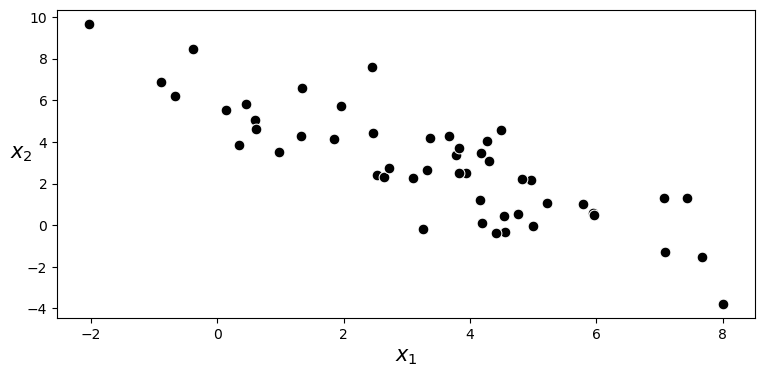

In [16]:
fig = plt.figure(figsize = (9,4)) 
plt.xlabel(r'$x_1$',fontsize = 15);plt.ylabel(r'$x_2$',fontsize = 15,rotation = 0);
plt.scatter(X_original[0,:],X_original[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

- Now we can implement the least squares cost function.  

- To stay consistent with our style for implementing cost functions, we will input package the weights for $\mathbf{C}$ and $\mathbf{W}$ in a single input list `w` as `w = [C,W]`.

- Once inside the cost function we can then simply strip off each matrix of weights and compute the cost function, as shown below in the implementation.

In [17]:
def least_squares(w):  
    C = w[0]
    W = w[1]
    cost = np.sum((np.dot(C,W) - X)**2)
    return cost/float(X.shape[1])

- Now make a run of $100$ gradient descent steps with a fixed steplength parameter $\alpha = 1$ for all steps in order to minimize the PCA Least Squares cost function implemented above.  


- Here we use the implementation of gradient descent given in [Section 3.6](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_6_Descent.html), which we employ via a backend file.


- With our gradient descent run complete we can plot the associated cost function history to make sure the method has converged sufficiently for our settings.  We do this below.

In [29]:
g = least_squares; max_its = 100; alpha_choice = 10**(0);

In [30]:
num_elements = 2; scale = 0.1;
#np.random.seed(0);
C = scale*np.random.randn(X.shape[0],num_elements)
W = scale*np.random.randn(num_elements,X.shape[1])
w = [C,W]

In [31]:
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w)

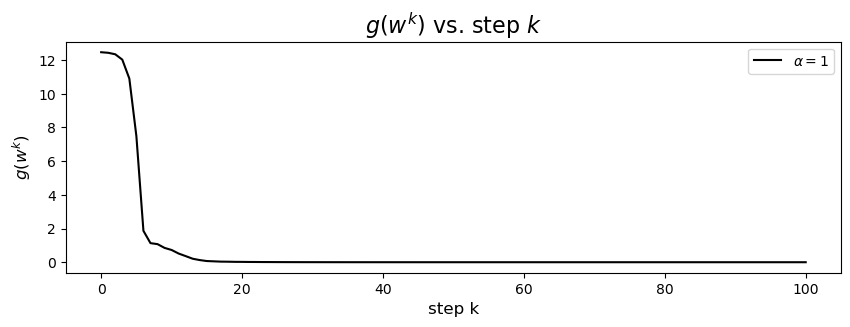

In [32]:
plt.figure(figsize=(10,3))
plt.plot(range(0,max_its+1), cost_history, 'k-', label = r'$\alpha=1$')
plt.title(r'$g(w^k)$ vs. step $k$', fontsize=16)
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.legend()
plt.show()

In [33]:
C = weight_history[-1][0]

In [34]:
X_new = copy.deepcopy(X)
X_new = X.T

In [35]:
# swing through points and compute coeffecients
alphas = []
for k in range(X_new.shape[0]):
    vec3 = X_new[k,:]   
    vec3.shape = (len(vec3),1)
    b = vec3
    alpha = np.linalg.solve(C,b)
    alphas.append(alpha)

In [36]:
alphas = np.stack(alphas, axis=0 )

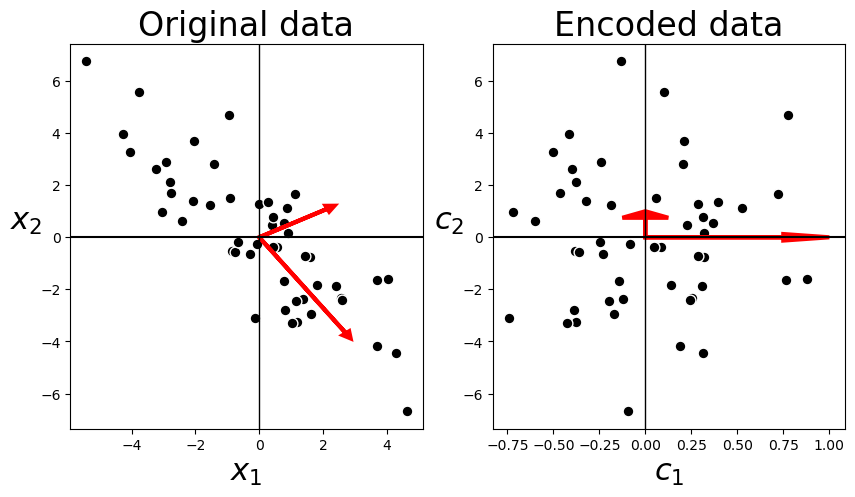

In [37]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X_new[:,0],X_new[:,1],s = 60, c = 'k',edgecolor = 'w',linewidth = 1)
ax2.scatter(alphas[:,0],X_new[:,1],s = 60, c = 'k',edgecolor = 'w',linewidth = 1)

vector_draw(C[:,0].flatten(),ax1,color = 'red',zorder = 1)
vector_draw(C[:,1].flatten(),ax1,color = 'red',zorder = 1)
vec1 = np.array([1,0]).flatten()
vec2 = np.array([0,1]).flatten()
vector_draw(vec1.flatten(),ax2,color = 'red',zorder = 1)
vector_draw(vec2.flatten(),ax2,color = 'red',zorder = 1)
ax1.axhline(y=0, color='k', linewidth=1.5,zorder = 1)
ax1.axvline(x=0, color='k', linewidth=1,zorder = 1)
ax2.axhline(y=0, color='k', linewidth=1.5,zorder = 1)
ax2.axvline(x=0, color='k', linewidth=1,zorder = 1)
ax1.set_xlabel(r'$x_1$',fontsize = 22)
ax1.set_ylabel(r'$x_2$',fontsize = 22,rotation = 0,labelpad = 10)
ax1.set_title('Original data',fontsize = 24)
ax2.set_xlabel(r'$c_1$',fontsize = 22)
ax2.set_ylabel(r'$c_2$',fontsize = 22,rotation = 0,labelpad = 10)
ax2.set_title('Encoded data',fontsize = 24)
plt.show()

- To empirically validate (at least to some degree) the notion that proper minimization will - in this instance - recover essentially any two random vectors, we show the results of three more runs of gradient descent using the same parameters as above but with a random initialization in each instance.  


- We plot the best recovered basis in each instance afterwards, and as we can see each instance differs considerably from the others (recovering two linearly independent vectors in each case).

In [38]:
best_bases = []
num_runs = 3
max_its = 100; alpha_choice = 10**(0);
num_elements = 2; scale = 0.1; g = least_squares;
for i in range(num_runs):
    # generate random initial matrices
    #np.random.seed(0)
    C = scale*np.random.randn(X.shape[0],num_elements)
    W = scale*np.random.randn(num_elements,X.shape[1])
    w = [C,W]

    # run gradient descent to minimize the PCA least squares cost
    weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w)

    # pluck out best weights
    ind = np.argmin(cost_history)
    C_best = weight_history[ind][0]
    best_bases.append(C_best)

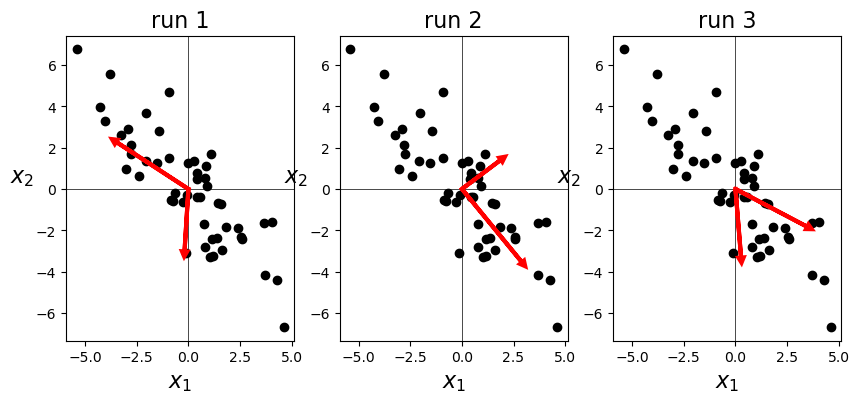

In [39]:
weights = np.array(best_bases)
num_runs = np.ndim(weights)

# plot data
fig = plt.figure(figsize = (10,4))
gs = gridspec.GridSpec(1, num_runs) 
for run in range(num_runs):
    # create subplot
    ax = plt.subplot(gs[run],aspect = 'equal'); 
    w_best = weights[run]
    ax.scatter(X[0,:],X[1,:],c = 'k')
    vector_draw(w_best[:,0],ax,color = 'red',zorder = 1)
    vector_draw(w_best[:,1],ax,color = 'red',zorder = 1)
    ax.axhline(linewidth=0.5, color='k',zorder = 0)
    ax.axvline(linewidth=0.5, color='k',zorder = 0)
    ax.set_title('run ' + str(run + 1),fontsize=16)
    ax.set_xlabel(r'$x_1$',fontsize = 16)
    ax.set_ylabel(r'$x_2$',fontsize = 16,rotation = 0,labelpad = 10)

#### <span style="color:#a50e3e;">Example. </span> Learning a proper subspace via gradient descent

- In this example we use gradient descent to minimize the PCA Least Squares cost in order to learn the best two-dimensional subspace representation of an $N=3$ dimensional dataset consisting of $100$ points.   


- We load in the dataset below and mean-center it.

- Now we make a run of $100$ gradient descent steps with a fixed steplength value of $\alpha = 1$ for each step.  


- With these settings gradient descent converges very well.  Notice: to learn $2$ basis elements we initialize $\mathbf{C}$ as a random $3 \times 2 $ matrix (i.e., it will have only two spanning vectors), and likewise initialize each weight vector to have only two entries.

In [40]:
X_original = np.loadtxt(readDataPath + '3d_span_data.csv',delimiter=',')

# center data
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; max_its = 100; alpha_choice = 10**(0);

# set up initialization
scale = 0.1;
C = scale*np.random.randn(3,2)
W = scale*np.random.randn(2,100)
w = [C,W]

In [41]:
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w)

- With this run complete we can plot our two learned spanning vectors $\mathbf{c}_1$ and $\mathbf{c}_2$, the two-dimensional subspace it spans, etc.,  We do this below.  


- The left panel shows the original data (as gray dots), learned spanning vectors (shown as red arrows), and corresponding subspace colored in light red.  


- This is the very best two-dimensional subspace representation for the input data.  In the middle panel we show the corresponding learned weight vectors / encodings $\mathbf{w}_p$ of the original input $\mathbf{x}_p$ in the space spanned by the recovered spanning vectors.  

- In the right panel we show the original data space again and the decoded data points (gray dots with red borders) - i.e., the projection of each datapoint onto the space spanned by our learned basis.  


- As discussed previously, the decoded version of the $p^{th}$ point $\mathbf{x}_p$ is computed as $\mathbf{C}\mathbf{w}_p$, where $\mathbf{C}$ and $\mathbf{w}_p$ are the fully learned basis and encoding for the $p^{th}$ point. 

In [42]:
C = weight_history[-1][0]

In [43]:
view = [15,105]

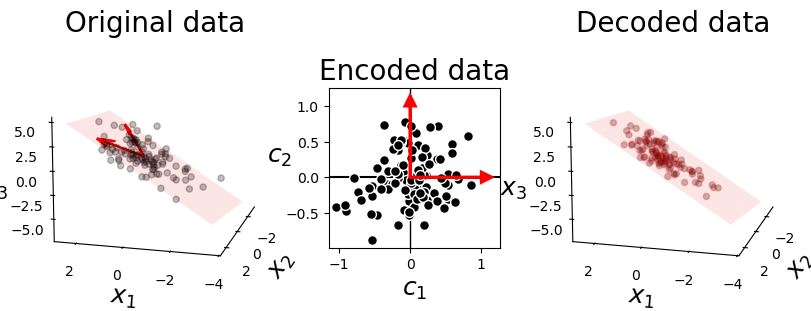

In [44]:
fig = plt.figure(figsize = (10,4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1.5,1,1.5]) 
ax1 = plt.subplot(gs[0],projection='3d');
ax2 = plt.subplot(gs[1],aspect = 'equal');
ax3 = plt.subplot(gs[2],projection='3d');
ax1.scatter(X[0,:],X[1,:],X[2,:],c = 'k',alpha = 0.25)
a = np.zeros((2,1))
ax1.quiver(a,a,a,C[0,:],C[1,:],C[2,:],color = 'r')
plot_hyperplane(X.T,C,ax1)

ax1.view_init(view[0],view[1])
ax1.set_xlabel(r'$x_1$',fontsize = 18,labelpad = 5)
ax1.set_ylabel(r'$x_2$',fontsize = 18,labelpad = 5)
ax1.zaxis.set_rotate_label(False)  # disable automatic rotation
ax1.set_zlabel(r'$x_3$',fontsize = 18,rotation = 0)
ax1.set_title('Original data',fontsize = 20)
move_axis_left(ax1)

#### plot encoded data ####
W = np.linalg.solve(np.dot(C.T,C),np.dot(C.T,X))
ax2.scatter(W[0,:],W[1,:],c = 'k',edgecolor = 'w',linewidth = 1,s = 50,zorder = 2)
# paint arrows on data
ax2.arrow(0,0,0,1,fc="r", ec="r",head_width=0.15, head_length=0.15,linewidth = 2,zorder = 3)
ax2.arrow(0,0,1,0,fc="r", ec="r",head_width=0.15, head_length=0.15,linewidth = 2,zorder = 3) 
ax2.set_xlabel(r'$c_1$',fontsize = 18)
ax2.set_ylabel(r'$c_2$',fontsize = 18,rotation = 0)
ax2.axhline(y=0, color='k', linewidth=1.5,zorder = 1)
ax2.axvline(x=0, color='k', linewidth=1,zorder = 1)
ax2.set_title('Encoded data',fontsize = 20)

X_d = np.dot(C,W)
ax3.scatter(X_d[0,:],X_d[1,:],X_d[2,:],c = 'k',edgecolor = 'r',linewidth = 1,alpha = 0.25)
plot_hyperplane(X.T,C,ax3)
ax3.view_init(view[0],view[1])
ax3.set_xlabel(r'$x_1$',fontsize = 18,labelpad = 5)
ax3.set_ylabel(r'$x_2$',fontsize = 18,labelpad = 5)
ax3.zaxis.set_rotate_label(False)  # disable automatic rotation
ax3.set_zlabel(r'$x_3$',fontsize = 18,rotation = 0)
ax3.set_title('Decoded data',fontsize = 20)
move_axis_left(ax3)

## The linear Autoencoder

- As detailed in the previous Section, if our $K$ spanning vectors concatenated column-wise to form the spanning matrix $\mathbf{C}$ are orthonormal, then the encoding of each $\mathbf{x}_p$ may be written simply as $\mathbf{w}_p = \mathbf{C}^T \mathbf{x}_p$. 


- If we plug in this simple solution for $\mathbf{w}_p$ into the $p$th summand of the Least Squares cost above, we get a cost that is a function of \(\mathbf{C}\) 

$$
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2
$$


- We can think of this Least Squares as enforcing the Autoencoder formula shown previously to hold when properly minimized, and thus it is often referred to as the linear Autoencoder.  


- Instead of being given an encoding/decoding scheme for each data point, by minimizing this cost function we learn one.


- Even though we were led to the linear Autoencoder by assuming our spanning matrix $\mathbf{C}$ is orthonormal, we need not enforce this condition because it can be shown that the minima of the linear Autoencoder are indeed always orthonormal.

#### <span style="color:#a50e3e;">Example. </span>  Learning a linear Autoencoder using gradient descent

- In the left panel of the below figure, we show a mean-centered two-dimensional dataset, along with a single spanning vector (i.e., $K = 1$) learned to the data by minimizing the linear Autoencoder cost function above using gradient descent. 

- The optimal vector is shown as a red arrow in the left panel, the corresponding encoded data is shown in the middle panel, and the decoded data in the right panel along with the optimal subspace for the data (a line) shown in red.

In [45]:
def model(X,C):    
    W = np.dot(C.T,X) #encoding 
    a = np.dot(C,W) #decoding 
    return a

In [46]:
def autoencoder(C):
    cost = np.sum((model(X,C) - X)**2)
    return cost/float(X.shape[1])

In [47]:
X = np.loadtxt(readDataPath + '2d_span_data_centered.csv',delimiter=',')

In [48]:
# tune the autoencoder via gradient descent
g = autoencoder; alpha_choice = 10**(-4); max_its = 1000; C = 0.1*np.random.randn(2,1);
C = np.array([[-3.5],[3.5]])
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,C)

In [49]:
show_pc = True; scale = 150; encode_label = r'$\mathbf{c}_1$'; projmap = False;

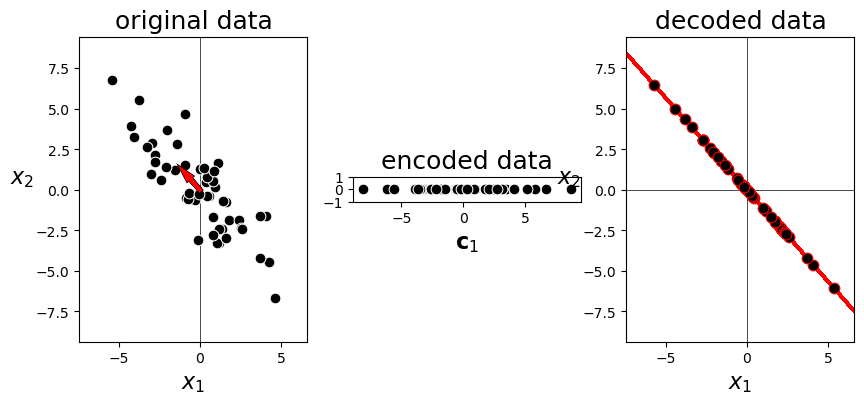

In [50]:
encoder = lambda a,b: np.dot(b.T,a)
decoder = lambda a,b: np.dot(b,a)
ind = np.argmin(cost_history)
w_best = weight_history[ind]
num_params = 0
if type(w_best)==list:
    num_params = len(w_best)
else:
    num_params = np.ndim(w_best) - 1
fig = plt.figure(figsize = (10,4))
gs = gridspec.GridSpec(1, 3) 
ax1 = plt.subplot(gs[0],aspect = 'equal'); 
ax2 = plt.subplot(gs[1],aspect = 'equal'); 
ax3 = plt.subplot(gs[2],aspect = 'equal');
ax1.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
if show_pc == True:
    for pc in range(np.shape(w_best)[1]):
        ax1.arrow(0, 0, w_best[0,pc], w_best[1,pc], head_width=0.25, head_length=0.5, fc='k', ec='k',linewidth = 4)
        ax1.arrow(0, 0, w_best[0,pc], w_best[1,pc], head_width=0.25, head_length=0.5, fc='r', ec='r',linewidth = 3)
v = 0; p = 0
if num_params == 2:
    # create encoded vectors
    v = encoder(X,w_best[0])
    # decode onto basis
    p = decoder(v,w_best[1])
else:
    # create encoded vectors
    v = encoder(X,w_best)
    # decode onto basis
    p = decoder(v,w_best)
if v.shape[0] == 1:
    z = np.zeros((1,np.size(v)))
    ax2.scatter(v,z,c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
elif v.shape[0] == 2:
    ax2.scatter(v[0],v[1].flatten(),c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
ax3.scatter(p[0,:],p[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'r')
xmin1 = np.min(X[0,:]); xmax1 = np.max(X[0,:])
xmin2 = np.min(X[1,:]); xmax2 = np.max(X[1,:])
xgap1 = (xmax1 - xmin1)*0.2; xgap2 = (xmax2 - xmin2)*0.2
xmin1 -= xgap1; xmax1 += xgap1
xmin2 -= xgap2; xmax2 += xgap2
for ax in [ax1,ax2,ax3]:
    if ax == ax1 or ax == ax3:
        ax.set_xlim([xmin1,xmax1])
        ax.set_ylim([xmin2,xmax2])
        ax.set_xlabel(r'$x_1$',fontsize = 16)
        ax.set_ylabel(r'$x_2$',fontsize = 16,rotation = 0,labelpad = 10)
        ax.axvline(linewidth=0.5, color='k',zorder = 0)
    else:
        ax.set_ylim([-1,1])
        if len(encode_label) > 0:
            ax.set_xlabel(encode_label,fontsize = 16)
ax.axhline(linewidth=0.5, color='k',zorder = 0)
ax1.set_title('original data',fontsize = 18)
ax2.set_title('encoded data',fontsize = 18)
ax3.set_title('decoded data',fontsize = 18)

# plot learned manifold
a = np.linspace(xmin1,xmax1,400)
b = np.linspace(xmin2,xmax2,400)
s,t = np.meshgrid(a,b)
s.shape = (1,len(a)**2)
t.shape = (1,len(b)**2)
z = np.vstack((s,t))
v = 0; p = 0
if num_params == 2:
    # create encoded vectors
    v = encoder(z,w_best[0])
    # decode onto basis
    p = decoder(v,w_best[1])
else:
    # create encoded vectors
    v = encoder(z,w_best)
    # decode onto basis
    p = decoder(v,w_best)

ax3.scatter(p[0,:],p[1,:],c = 'k',s = 1.5,edgecolor = 'r',linewidth = 1,zorder = 0)
plt.show()

##  Principal Component Analysis

- The linear Autoencoder cost may have many minimizers, of which the set of principal components is a particularly important one. 


- The spanning set of principal components always provide a consistent skeleton for a dataset, with its members pointing in the dataset’s *largest directions of orthogonal variance*. 


- Employing this particular solution to the linear Autoencoder is often referred to as Principal Component Analysis, or PCA for short, in practice.

- This idea is illustrated for a prototypical $N = 2$ dimensional dataset in Figure 8.6, where the general elliptical distribution of the data is shown in light grey. 


- A scaled version of the first principal component of this dataset points in the direction in which the dataset is most spread out, also called its largest direction of variance. 


- A scaled version of the second principal component points in the next most important direction in which the dataset is spread out that is orthogonal to the first.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/pca_classic.png' width="50%" height="auto" alt=""/>
  <figcaption>    <em> The classic orthogonal PCA minimizer of the autoencoder cost function.  The elements of this basis point in the orthogonal directions of variance of the dataset, that is the orthogonal directions in which the dataset is most spread out.
</em>  </figcaption> 
</figure>

- This special orthonormal minimizer of the linear Autoencoder is given by the eigenvectors of the so-called covariance matrix of the data.

- Denoting by $\mathbf{X}$ the $N \times P$ data matrix consisting of our $P$ mean-centered input points stacked column-wise

\begin{equation}
\mathbf{X} = 
\begin{bmatrix}
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert \\
\,\, \mathbf{x}_1 \,\,\, \mathbf{x}_2 \,\,\, \cdots \,\,\, \mathbf{x}_P \\
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert 
\end{bmatrix}
\end{equation}

- The orthogonal basis provided by this special solution (called the *Principal Components* of a dataset) can be computed (as a minimum of the Autoencoder cost function) as the *eigenvectors* of the corresponding *correlation matrix* of this data

\begin{equation}
\text{covariance matrix of } \, \mathbf{X}: = \, \frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T
\end{equation}

- Denoting the eigenvector/value decomposition of the covariance matrix 
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T$ is given as

\begin{equation}
\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T = \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T
\end{equation}

- then above the orthonormal basis we recover is given precisely by the eigenvectors above, i.e., $\mathbf{C} = \mathbf{V}$.  


- Again, these are referred to in the jargon of machine learning as the *principal components* of the data.

- Moreover, the variance in each (principal component) direction is given precisely by the corresponding eigenvalue in $\mathbf{D}$.

#### <span style="color:#a50e3e;">Example. </span>  Principal Components

- In the left panel below we show the mean-centered data first displayed in the prior example, along with its two principal components (pointing in the two orthogonal directions of greatest variance in the dataset) shown as red arrows. 


- In the right panel we show the encoded version of the data in a space where the principal components are in line with the coordinate axes.

In [40]:
'''
A function for computing the principal components of an input data matrix.  Both
principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
are returned
'''
def compute_pcs(X,lam):
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

In [41]:
'''
A function for producing the full PCA transformation on an input dataset X.  
'''
def pca_transform_data(X,**kwargs):
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    D,V = compute_pcs(X,lam)
    V = V[:,-num_components:]
    D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V

In [42]:
X_original = np.loadtxt(readDataPath + '2d_span_data.csv',delimiter=',')

In [43]:
X = center(X_original)

In [44]:
W,V = pca_transform_data(X)
pcs = V

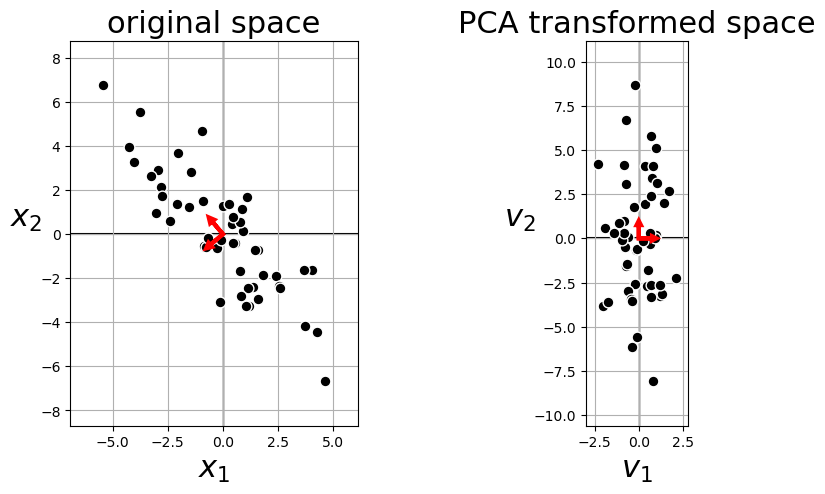

In [45]:
fig = plt.figure(figsize = (10,5))
gs = gridspec.GridSpec(1, 2) 
ax1 = plt.subplot(gs[0],aspect = 'equal');
ax2 = plt.subplot(gs[1],aspect = 'equal');
ars = np.eye(2)
c = 1
for ax,pt,ar in zip([ax1,ax2],[X,W],[pcs,ars]): 
    # set viewing limits for originals
    xmin = np.min(pt[0,:])
    xmax = np.max(pt[0,:])
    xgap = (xmax - xmin)*0.15
    xmin -= xgap
    xmax += xgap
    ymin = np.min(pt[1,:])
    ymax = np.max(pt[1,:])
    ygap = (ymax - ymin)*0.15
    ymin -= ygap
    ymax += ygap

    # scatter points
    ax.scatter(pt[0,:],pt[1,:],s = 60, c = 'k',edgecolor = 'w',linewidth = 1,zorder = 2)

    # plot original vectors
    vector_draw(ar[:,0].flatten(),ax,color = 'red',zorder = 3)
    vector_draw(ar[:,1].flatten(),ax,color = 'red',zorder = 3)

    # plot x and y axes, and clean up
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k', linewidth=1.5,zorder = 1)
    ax.axvline(x=0, color='k', linewidth=1,zorder = 1)
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.grid('off')
    
    # plot title
    if c == 1:
        ax.set_title('original space',fontsize = 22)
        ax.set_xlabel(r'$x_1$',fontsize = 22)
        ax.set_ylabel(r'$x_2$',fontsize = 22,rotation = 0,labelpad = 10)
    if c == 2:
        ax.set_title('PCA transformed space',fontsize = 22)
        ax.set_xlabel(r'$v_1$',fontsize = 22)
        ax.set_ylabel(r'$v_2$',fontsize = 22,rotation = 0,labelpad = 10)
    c+=1

##  K-means Clustering

- Previously, we saw how Principal Component Analysis can be used as a basis for various normalization schemes. 


- As well as a tool for simplifying a high dimensional dataset by properly reducing its *input* or *feature* dimension.  


- The subject now is another tool for simplifying data, however here the problem is not (necessarily) that the data lives in high dimension but that there are simply too many data points to process (either by an algorithm or a human interpreter).  

- The focus - the *K-means algorithm* - is an elementary example of another set of unsupervised learning methods called *clustering algorithms*.  


- These algorithms are designed to (properly) reduce the number of points in a dataset, which we refer to as the *data dimension* of a dataset...


- ...and in doing so help us understand the structure of our data.

###  Representing a dataset via clusters

- One very simple way to simplify a dataset is by grouping together nearby points into *clusters*.  

- We will denote our set of $P$ points generically as $\mathbf{x}_1,\,\mathbf{x}_2,\,...,\mathbf{x}_P$$ all of dimension $N$. 

- To keep things as generally applicable as possible we will also use the notation $K$ to denote the number of clusters in a dataset.  

- Because each cluster has a centroid we need notation for this as well, and we will use $\mathbf{c}_1,\,\mathbf{c}_2,\,...,\mathbf{c}_K$ to denote these where $\mathbf{c}_k$ is the centroid of the $k^{th}$ cluster.  


- Finally we need a notation to denote the set of points that belong to each cluster.  We denote the set of indices of those points belonging to the $k^{th}$ cluster as

\begin{equation}
\mathcal{S}_k =  \left\{ p\,\, \lvert \,\,\text{if $\mathbf{x}_p$ belongs to the $k^{th}$ cluster } \right\}.
\end{equation}

- With all of our notation in hand we can now better describe the clustering scenario.  


- Again, note here we have assumed that we have identified each cluster and its centroid.  


- Firstly, because the centroid denotes the center of a cluster it seems intuitive that each one should be expressible as the average of the points assigned to each cluster.  

- Algebraically this is to say that

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}


- This formula confirms the intuition that each centroid represents a chunk of the data - the average of those points belonging to each cluster.  


- Next we can state mathematically an obvious and implicit fact about the clustering scenario above: that each point belongs to the cluster whose centroid it is closest to. 

- To express this algebraically for a given point $\mathbf{x}_p$ is simply say that the point must belong to the cluster where the distance to the centroid $\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2$ is minimal.  


- In other words, the point $\mathbf{x}_p$ belongs to or is *assigned* to cluster $k^{\star}$ if

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2
\end{equation}

- In the jargon of machine learning these are called cluster *assignments*.

###  Learning clusters to represent data

- We do not want to have to visually identify clusters in a dataset ourselves, and in any being constrained three dimensions if the dimension of of a dataset is greater than $N=3$ there is no way for us humans to do this anyway.  Instead we want an algorithm that will do this for us automatically. 

- Thankfully we can do this rather easily using the framework detailed above for mathematically describing clusters - the resulting algorithm being called the *K-means clustering algorithm*.  As with many of the algorithms we have seen K-means is an *iterative method*, meaning that we will refine the ideal location for our cluster centroids / cluster assignments over a number of update steps.

- To get started -  let us say that we want to cluster a dataset of $P$ points into $K$ clusters automatically.  


- Note here that we will fix $K$, and address how to properly decide on its value later.  


- Now to state the obvious - remember - we know neither a) the locations of each cluster centroid nor b) the cluster assignments.

- Since we do not know where the clusters nor their centroids are located we can start off by taking a random guess at the locations of our $K$ centroids (we have to start somewhere).  


- This 'random guess' - our initialization - for the $K$ centroids could be a random subset of $K$ of our points, or any number of other types of initialization.


- With our initial centroid locations decided on we can then determine cluster assignments by simply looping over our points and for each $\mathbf{x}_p$ finding its closest centroid using the formula we saw above

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2.
\end{equation}

- Now we have both an initial guess at our centroids and clustering assignments.  


- With our cluster assignments in hand we can then update our centroid locations - as the average of the points assigned to each cluster

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}

- To further refine our centroids / clusters we can now just repeat the above two-step process of re-assigning points based on our new centroid locations and then updating the centroid locations as the average of those points assigned to each cluster.  


- We can halt doing so after e.g., a pre-defined number of maximum iterations or when the cluster centroids to not change location very much from one iteration to the next.

### The K-means algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">

<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,\cdots,\mathbf{x}_P$, initializations for centroids $\mathbf{c}_1,...,\mathbf{c}_K$, and maximum number of iterations $J$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,j = 1,\ldots,J$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update cluster assignments</code><br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\text{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update centroid locations</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,k = 1,\ldots,K$<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; denote $\mathcal{S}_{k}$ the index set of points $\mathbf{x}_{p}$ currently assigned to the $k^{th}$ cluster<br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; update $\mathbf{c}_k$ via $\mathbf{c}_{k}=\frac{1}{\left|\mathcal{S}_{k}\right|}\underset{p\in\mathcal{S}_{k}}{\sum}\mathbf{x}_{p}$<br>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp; <code>end for</code><br>

<strong>13:</strong>&nbsp;&nbsp; <code># Update cluster assignments using final centroids</code><br>

<strong>14:</strong>&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>15:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\text{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>16:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>17:</strong>&nbsp; <strong>output:</strong> optimal centroids and assignments<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example. </span> K-means failures due to a poor choice of initialization

- In this example we show how K-means can fail due to a poor choice of initial centroids.

- Regardless, one can intuit that the quality of a K-means clustering surely depends on a high quality initialization.  

- What does a good initialization look like?  


- Generally speaking, a good initializations is one where the initial centroids are spread evenly throughout the distribution of the data.


- Conversely, a poor initialization is typically one where all of the initial centroids are bunched up together in a small region of the space.  


- This can make it difficult for the centroids to spread out effectively, leading to less than optimal clusterings or even 'empty clusters' (i.e., those to which no points are finally assigned).

- The first and most fundamental issue is that of *empty clusters*, meaning clusters with no points assigned to them.  


- It is indeed possible, for some unfortunate initialization choices, for clusters to end up being empty when running K-means.  


- This is not an overly common occurrence, but is still worth noting. 

- We illustrate the empty-cluster problem below - where we make a run of $K = 3$ K-means clustering using the dataset above and a particular random initialization for the cluster centroids.  


- Here we choose a completely random set of points to initialize our centroids with, instead of a random subset of our training data, because it is easier to 'trip up' K-means doing so.  


- The animation / slider mechanism below works precisely as in the previous example, with each iteration shown in multiple frames, and moving the slider left to right controlling the iteration of K-means being shown.

In [46]:
def update_assignments(data,centroids):
    P = np.shape(data)[1]
    assignments = []
    for p in range(P):
        # get pth point
        x_p = data[:,p][:,np.newaxis]
        
        # compute distance between pth point and all centroids
        # using numpy broadcasting
        diffs = np.sum((x_p - centroids)**2,axis = 0)
        
        # determine closest centroid
        ind = np.argmin(diffs)
        assignments.append(ind)
    return np.array(assignments)

In [47]:
def update_centroids(data,old_centroids,assignments):
    K = old_centroids.shape[1]
    # new centroid container
    centroids = []
    for k in range(K):
        # collect indices of points belonging to kth cluster
        S_k = np.argwhere(assignments == k)
        
        # take average of points belonging to this cluster
        c_k = 0
        if np.size(S_k) > 0:
            c_k = np.mean(data[:,S_k],axis = 1)
        else:  # empty cluster
            c_k = copy.deepcopy(old_centroids[:,k])[:,np.newaxis]
        centroids.append(c_k)
    centroids = np.array(centroids)[:,:,0]
    return centroids.T

In [48]:
def my_kmeans(data,centroids,max_its):
    # collect all assignment and centroid updates - containers below
    all_assignments = []
    all_centroids = [centroids]
    
    # outer loop - alternate between updating assignments / centroids
    for j in range(max_its):
        # update cluter assignments
        assignments = update_assignments(data,centroids)
        
        # update centroid locations
        centroids = update_centroids(data,centroids,assignments)
        
        # store all assignments and centroids
        all_assignments.append(assignments)
        all_centroids.append(centroids)
        
    # final assignment update
    assignments = update_assignments(data,centroids)
    all_assignments.append(assignments)

    return all_centroids,all_assignments

In [49]:
def compute_AVGICD(data,centroids,assignments): #Compute Average Intra-cluster Distance
    P = len(assignments)
    K = np.shape(centroids)[1]
    error = 0
    for k in range(K):
        centroid = centroids[:,k]
        ind = np.argwhere(assignments == k)
        if np.size(ind) > 0:
            ind = [s[0] for s in ind]    
            for i in ind:
                pt = data[:,i]
                error += np.linalg.norm(centroid - pt)
    # divide by the average
    error /= float(P)
    return error

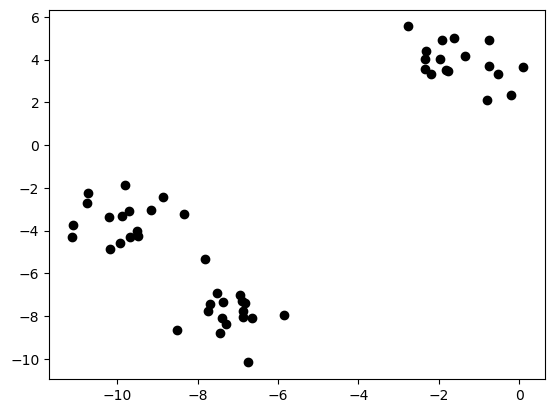

In [50]:
P = 50 ## Number of data points
blobs = datasets.make_blobs(n_samples=P, random_state=1,centers = 3)
data = np.transpose(blobs[0])
plt.scatter(data[0,:],data[1,:],c = 'k')
plt.show()

In [51]:
def plot_clusters(data, init_centroids, max_its, averageICDFlag = False):
    all_centroids,all_assignments = my_kmeans(data,init_centroids,max_its-1)
    fig = plt.figure(figsize = (5,5))
    P = np.shape(data)[1]
    K = init_centroids.shape[1]
    colors =  ['#1f77b4', '#ff7f0e','#2ca02c','#d62728','#9467bd', '#8c564b', '#e377c2','#7f7f7f', '#bcbd22','#17becf' ]
    gs = gridspec.GridSpec(1, 1) 
    ax = plt.subplot(gs[0],aspect = 'equal');
    ax.scatter(data[0,:],data[1,:],c = 'k',s = 100,edgecolor = 'w',linewidth = 1,zorder = 1)
    centroids = all_centroids[-1]
    assignments = all_assignments[-1]
    if (averageICDFlag): #Average Intra-Cluster Distance Flag
        error = compute_AVGICD(data,centroids,assignments)
        title = 'Average Intra-Cluster Distance = ' + str(round(error,1))
        ax.set_title(title,fontsize = 17)
    for k in range(K):
        ind = np.argwhere(assignments == k)
        if np.size(ind) > 0:
            ind = [s[0] for s in ind]    
            ax.scatter(data[0,ind],data[1,ind],color = colors[k],s = 100,edgecolor = 'k',linewidth = 1,zorder = 2)
        ax.scatter(centroids[0,k],centroids[1,k],c = colors[k],s = 400,edgecolor ='k',linewidth = 2,marker=(5, 1),zorder = 3)
    plt.show()
    

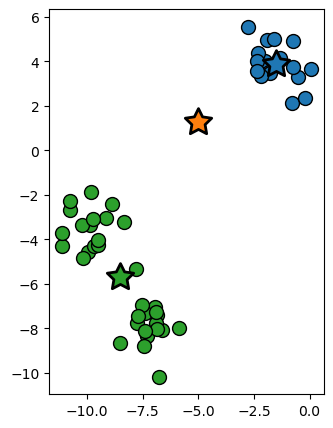

In [52]:
max_its = 5
init_centroids = np.array([[-0.57069626, -1.49710357,  0.02538411], [ 1.77397192,  2.98237079,  0.53539765]])
plot_clusters(data, init_centroids, max_its, averageICDFlag=False)

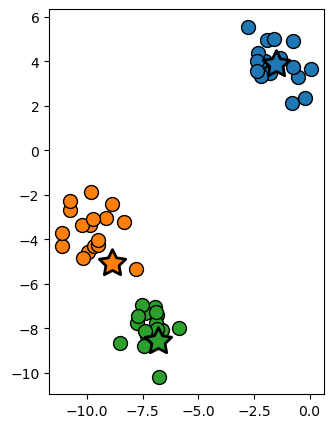

In [53]:
max_its = 5
init_centroids = np.array([[-5, -5,  -5], [ -10,  -10,  -10]])
plot_clusters(data, init_centroids, max_its, averageICDFlag=False)

- Once again the best antidote for this issue is to simply re-run the algorithm with a different initialization.  


- To determine the best clustering from set of runs we can use the *average distance of each point to its cluster centroid* - called the *average intra-cluster distance* - as an objective measure to rank the runs.  


- Denoting $\mathbf{c}_{k_p}$ the final cluster centroid of the $p^{th}$ point $\mathbf{x}_p$, then the average distance from each point to its respective centroid can be written as

\begin{equation}
\text{average intra-cluster distance} = \frac{1}{P}\sum_{p=1}^P \left \Vert \mathbf{x}_p - \mathbf{c}_{k_p} \right \Vert_2.
\end{equation}

- Computing this for each run of K-means we choose the final clustering that achieves the *smallest* such value as the best clustering arrangement.


- To illustrate the usage of the intra-cluster distance as a measurement for the quality of a clustering run, below we run ``K-means`` using the previous two initializations as well as one additional one that results in a perfect clustering on the toy dataset above. 


- We then plot the final clustering provided by each initialization - with the average intra-cluster distance in each printed above the panel.

In [54]:
# our first initialization --> leading to an empty cluster
init_centroids_1 = np.array([[-0.57069626, -1.49710357,  0.02538411],[ 1.77397192,  2.98237079,  0.53539765]])

In [55]:
# our second initialization --> leading to a sub-optimal clustering
pt_inds = [20,21,22]
init_centroids_2 = data[:,pt_inds]

In [56]:
# our third initialization --> leading to a perfect clustering
pt_inds = np.array([13, 10, 23])
init_centroids_3 = data[:,pt_inds]

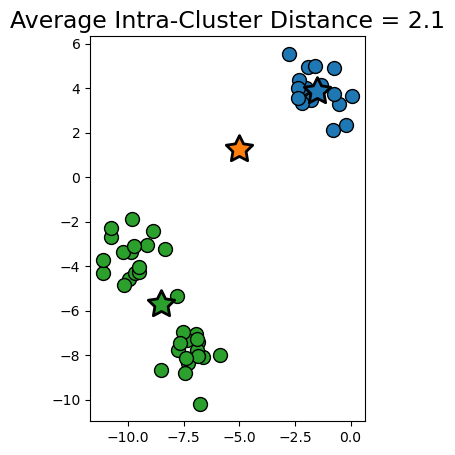

In [57]:
plot_clusters(data, init_centroids_1, max_its, averageICDFlag=True)

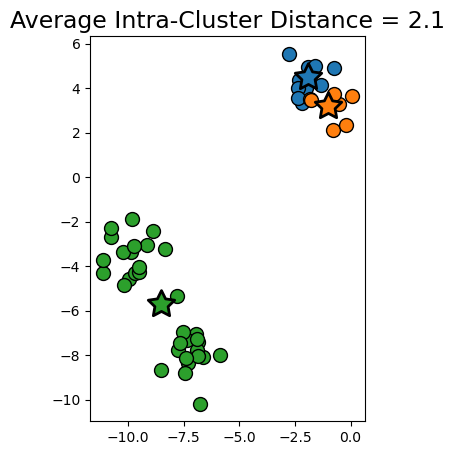

In [58]:
plot_clusters(data, init_centroids_2, max_its, averageICDFlag=True)

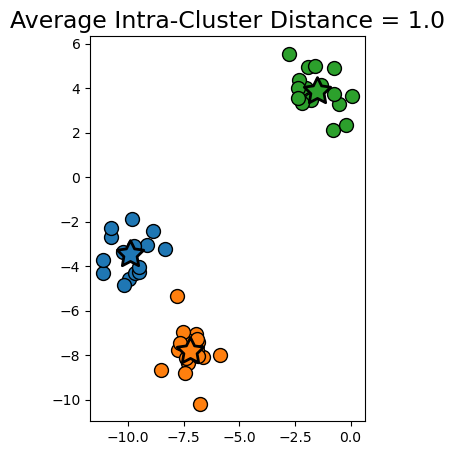

In [59]:
plot_clusters(data, init_centroids_3, max_its, averageICDFlag=True)

- Here we can see how the average intra-cluster distance provides us with a simple numerical way to compare the quality of various clusterings (when $K$ is fixed). 


- Above we can see how in this instance the empty-cluster scenario provided the worst value, the sub-optimal clustering a same value, and the optimal clustering a significantly lower value. 

#### <span style="color:#a50e3e;">Example.</span>  Choosing the ideal number of clusters $K$

- To determine the optimal setting of the parameter $K$ - i.e., the number of clusters in which to cluster the data - we typically must try a range of different values for $K$, run the K-means algorithm in each case, and compare the results using the average intra-cluster distance.  


- Of course if we achieve an optimal clusterings for each value of $K$ (perhaps running the algorithm multiple times for each value of $K$) then the intra-cluster distance should *always go down as we increase the value of $K$* since we are partitioning the dataset into more and more small chunks. 

- For example, in the Python cell below we plot the intra-cluster distance for the dataset used in the previous example resulting from 10 runs of K-means using $K=1,\ldots,10$, with a maximum number of 10 iterations per run.  


- This plot is often referred to in the jargon of machine learning as a *scree plot*.

In [60]:
def objective_vs_NClusters(data, K_range, max_its):
    ### outer loop - run K-means for each k ###
    K_errors = []
    for k in K_range:
        errors = []
        for j in range(5):
            # initialize
            P = np.shape(data)[1]
            random_inds = np.random.permutation(P)[:k]
            init_centroids = data[:,random_inds]

            # run K-means algo
            all_centroids,all_assignments = my_kmeans(data,init_centroids,max_its-1)
            centroids = all_centroids[-1]
            assignments = all_assignments[-1]

            # compute average error over dataset
            error = compute_AVGICD(data,centroids,assignments)
            errors.append(error)
            
        # take final error
        best_ind = np.argmin(errors)
        K_errors.append(errors[best_ind])   
    return  K_errors

In [61]:
K_range = [1,2,3,4,5,6,7,8,9,10]
max_its = 5

In [62]:
K_errors = objective_vs_NClusters(data, K_range, max_its)

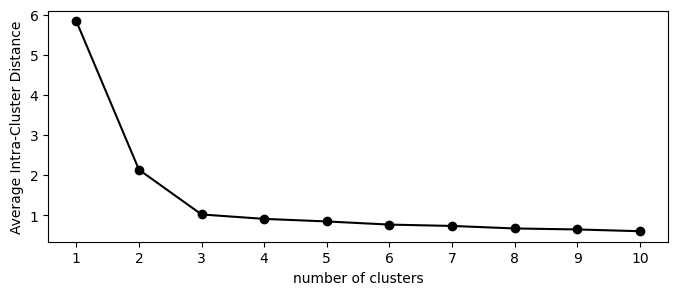

In [63]:
fig = plt.figure(figsize = (8,3))
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0]);
ax.plot(K_range,K_errors,'ko-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('Average Intra-Cluster Distance')
ax.set_xticks(K_range)
plt.show()

#### <span style="color:#a50e3e;">Example. </span> Larger Number of Clusters

In [64]:
data = np.loadtxt(readDataPath + '5cluster_2d_data.csv',delimiter = ',')
K_range = [1,2,3,4,5,6,7,8,9,10]
max_its = 5

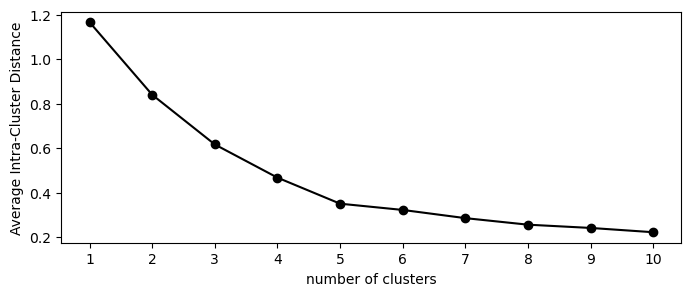

In [65]:
K_errors = objective_vs_NClusters(data, K_range, max_its)
fig = plt.figure(figsize = (8,3))
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0]);
ax.plot(K_range,K_errors,'ko-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('Average Intra-Cluster Distance')
ax.set_xticks(K_range)
plt.show()

In [66]:
r = np.arange(np.shape(data)[1])
num_clusters = 5
pts = np.random.permutation(r)[:num_clusters]
initial_centroids = data[:,pts]
max_its = 10

centroids,assignments = my_kmeans(data,initial_centroids,max_its)

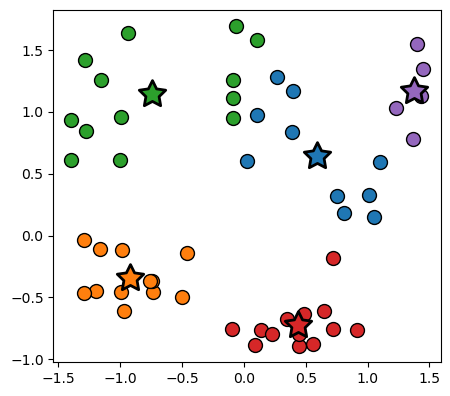

In [67]:
plot_clusters(data, initial_centroids, max_its, averageICDFlag=False)
